In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.4 MB/s eta 0:00:00


In [2]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-09-19 19:18:37--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 3.162.125.66, 3.162.125.95, 3.162.125.35, ...
Connecting to segment-anything.com (segment-anything.com)|3.162.125.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.09s   

2024-09-19 19:18:38 (2.33 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


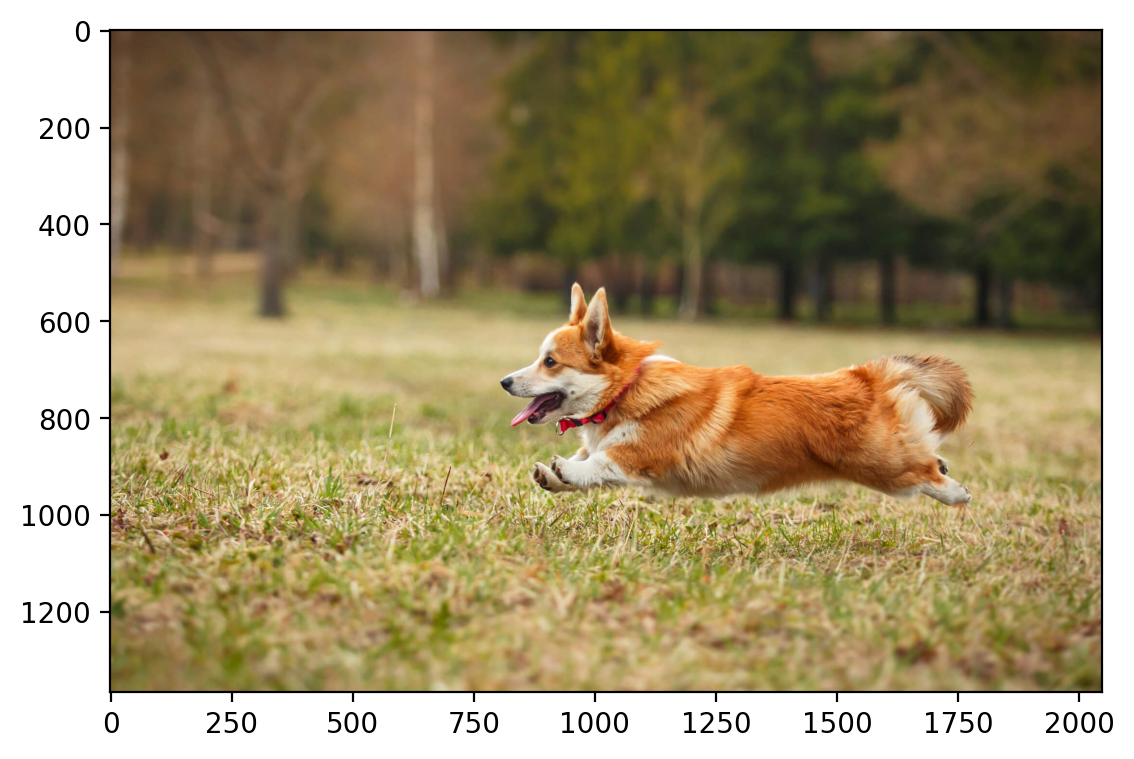

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler_img=MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1,1)).reshape(img.shape)
print(img_scaled.shape)

img_scaled = torch.tensor(img_scaled).float().to(device)

(3, 1365, 2048)


In [6]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

torch.Size([3, 300, 300])


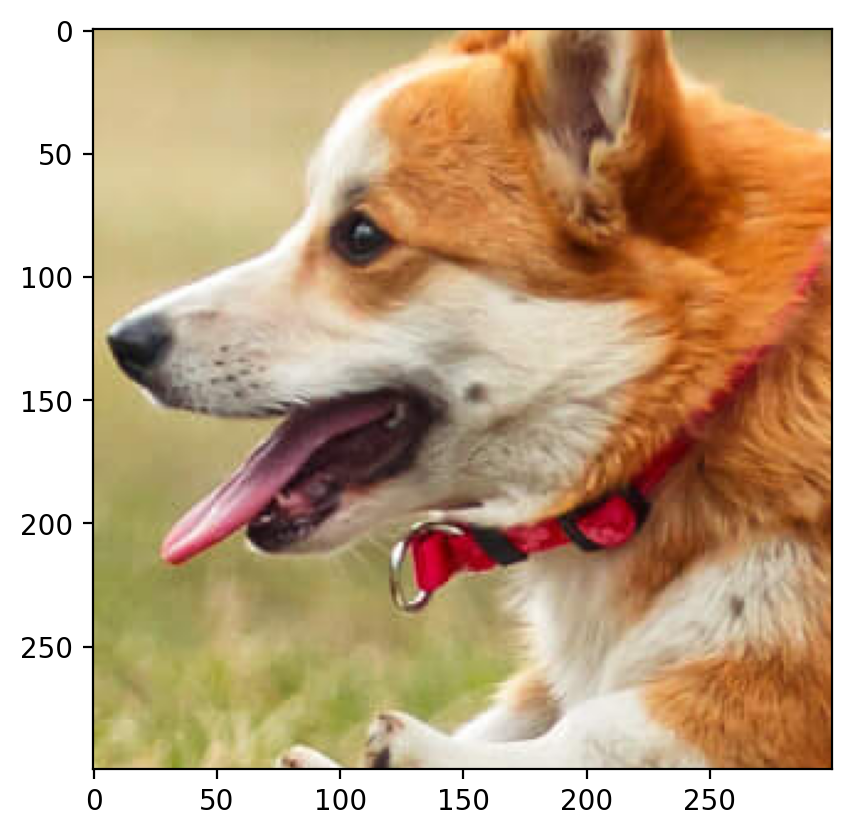

In [7]:
sample_img=torchvision.transforms.functional.crop(img_scaled,600,800,300,300)
plt.imshow(rearrange(sample_img,'c h w -> h w c').numpy())
print(sample_img.shape)

In [8]:
def create_patch(img,ht,wd,size):
  copy_img=img.clone()
  patch=copy_img[:,ht:ht+size,wd:wd+size]
  return patch

In [9]:
def matrix_factorization(A,r,E):

  A=A.to(device)

  np.random.seed(42)
  W=torch.randn(A.shape[0],r,requires_grad=True).to(device)
  H=torch.randn(r,A.shape[1],requires_grad=True).to(device)

  optimizer=torch.optim.Adam([W,H],lr=0.01)

  for e in range(E):
    matr_diff=A-torch.mm(W,H)
    loss=torch.norm(matr_diff)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return W,H,loss.item()

In [10]:
def replace_patch(img,ht,wd,patch):
  copy_img=img.clone()
  copy_img[:,ht:ht+patch.shape[1],wd:wd+patch.shape[2]]=patch
  return copy_img

In [11]:
def plot_images(orig_img,new_img,rank,title,rmse,psnr,patch):
  orig_img=highlight_patch(orig_img,patch[0],patch[1],patch[2],(1,0,0),1)
  new_img=highlight_patch(new_img,patch[0],patch[1],patch[2],(0,0,1),1)
  fig=plt.figure(figsize=(7,4))
  fig.suptitle(f'\n{title}    rank-{rank}     RMSE: {rmse}     PSNR:{psnr} : \n')
  plt.subplot(1,2,1)
  plt.title('Original Image')
  plt.imshow(rearrange(orig_img,'c h w -> h w c').numpy())
  plt.subplot(1,2,2)
  plt.imshow(rearrange(new_img,'c h w -> h w c').numpy())
  plt.title('Reconstructed Image')
  fig.tight_layout()
  plt.show()

In [12]:
def highlight_patch(image,ht,wd,size,color,thickness):

  copy_img=image.clone()
  copy_img[:,ht:ht+thickness,wd:wd+size]=torch.tensor(color).unsqueeze(-1).unsqueeze(-1)#top border
  copy_img[:,ht+size-thickness:ht+size,wd:wd+size]=torch.tensor(color).unsqueeze(-1).unsqueeze(-1)#bottom border
  copy_img[:, ht:ht+size, wd:wd+thickness] = torch.tensor(color).unsqueeze(-1).unsqueeze(-1)#left border
  copy_img[:, ht:ht+size, wd+size-thickness:wd+size] = torch.tensor(color).unsqueeze(-1).unsqueeze(-1)#right border

  return copy_img

In [13]:
def get_rmse(img1,img2):
  return torch.sqrt(torch.mean((img1-img2)**2))

def get_psnr(img1,img2):
  return 20*torch.log10(1/get_rmse(img1,img2))

In [14]:
patch_list=[(0,0,50,'Type-1 (single color)'),(60,30,50,'Type-2 (dual color)'),(175,100,50,'Type-3 Multi-color')]
rank_list=[5,10,25,50]

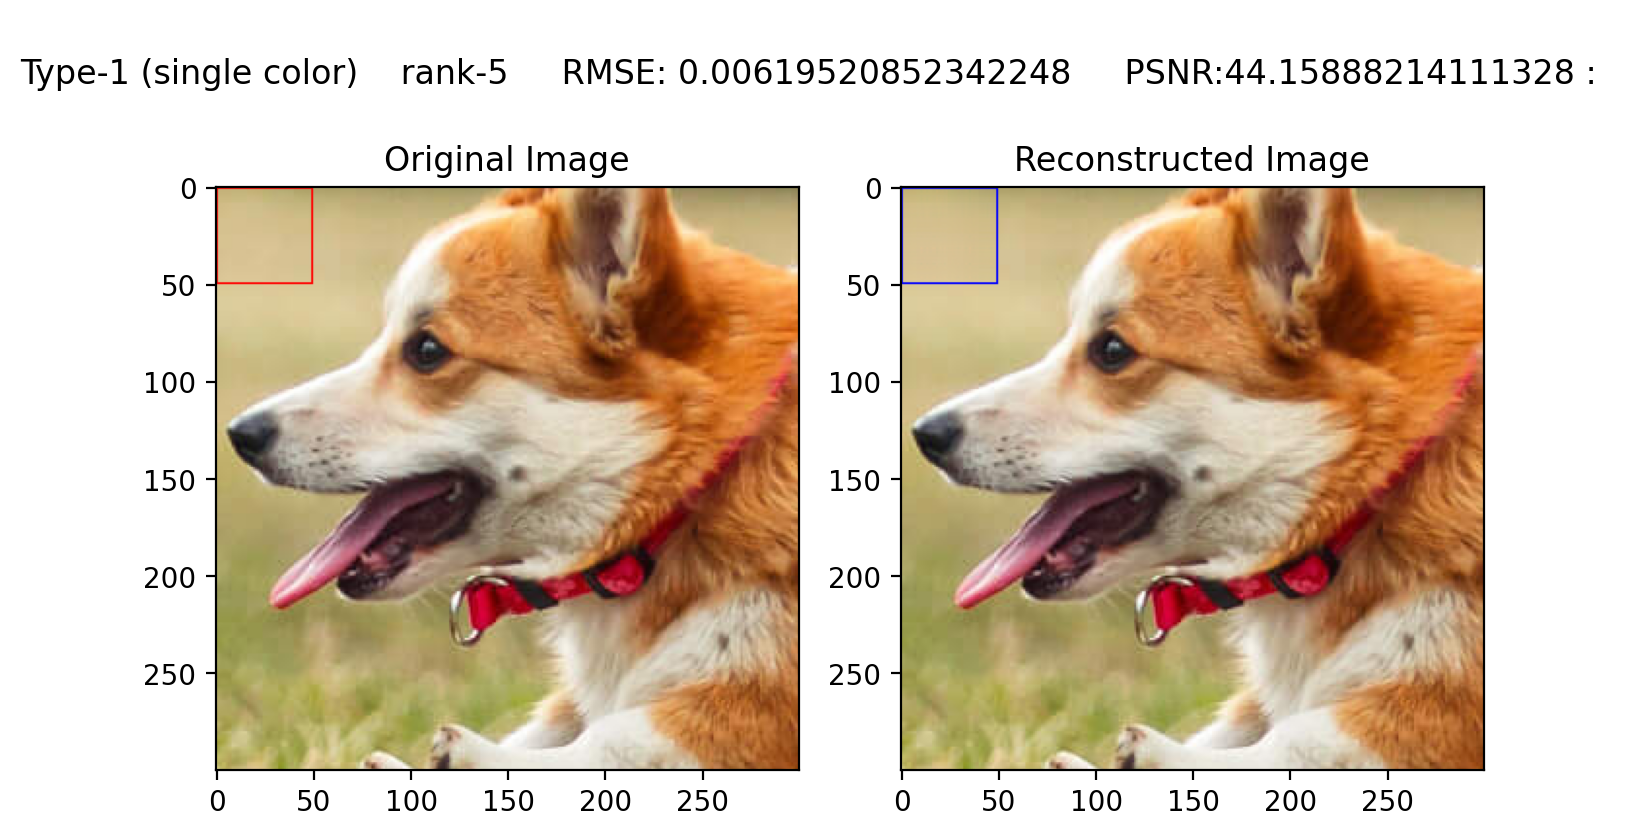

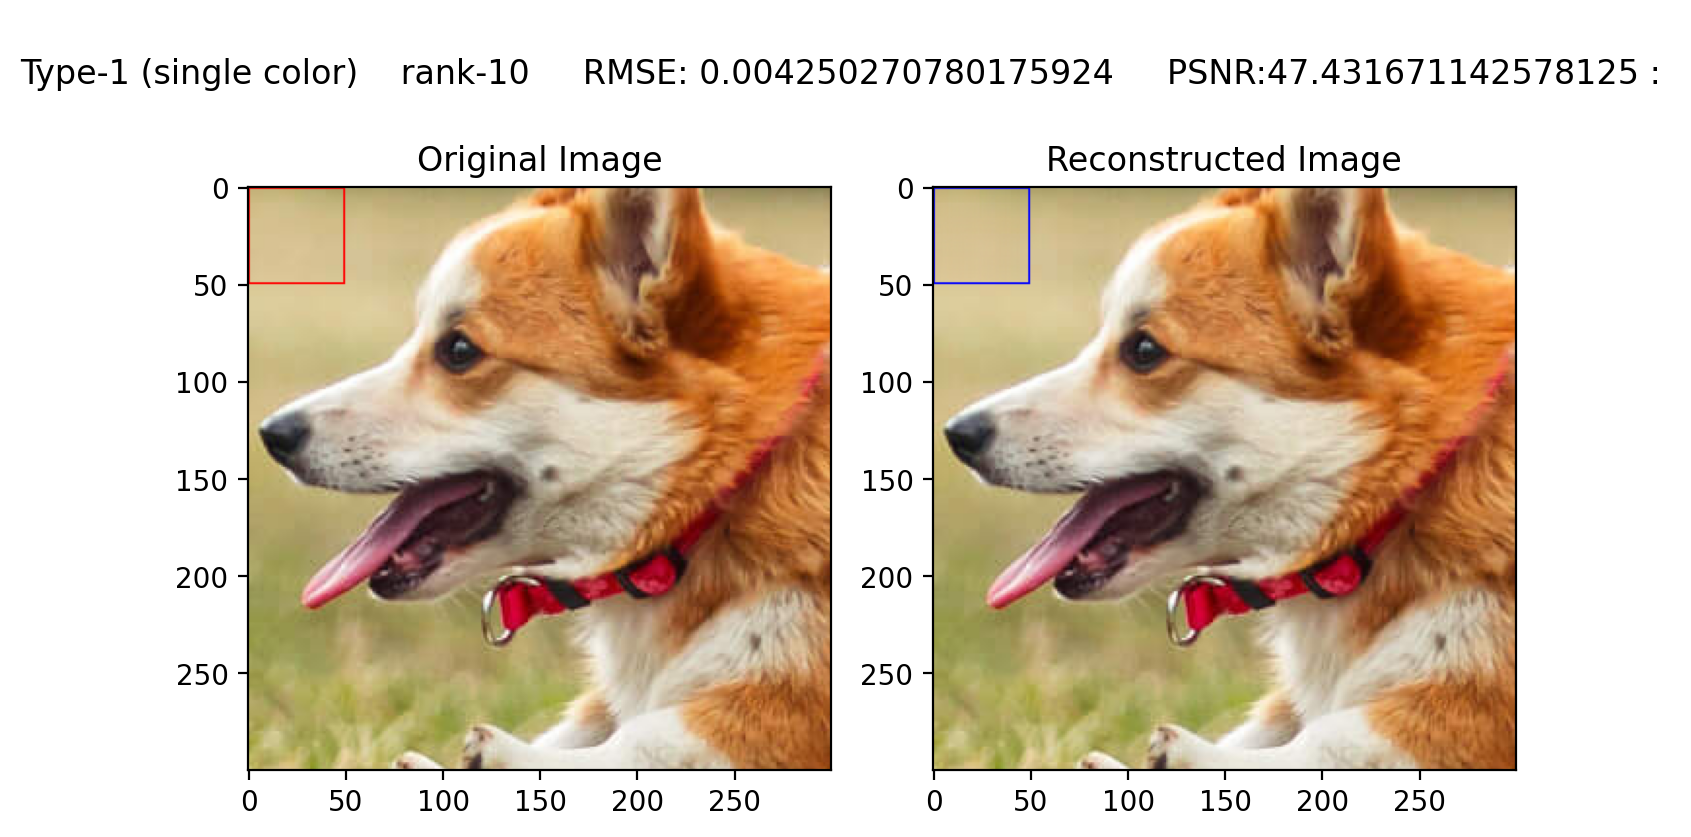

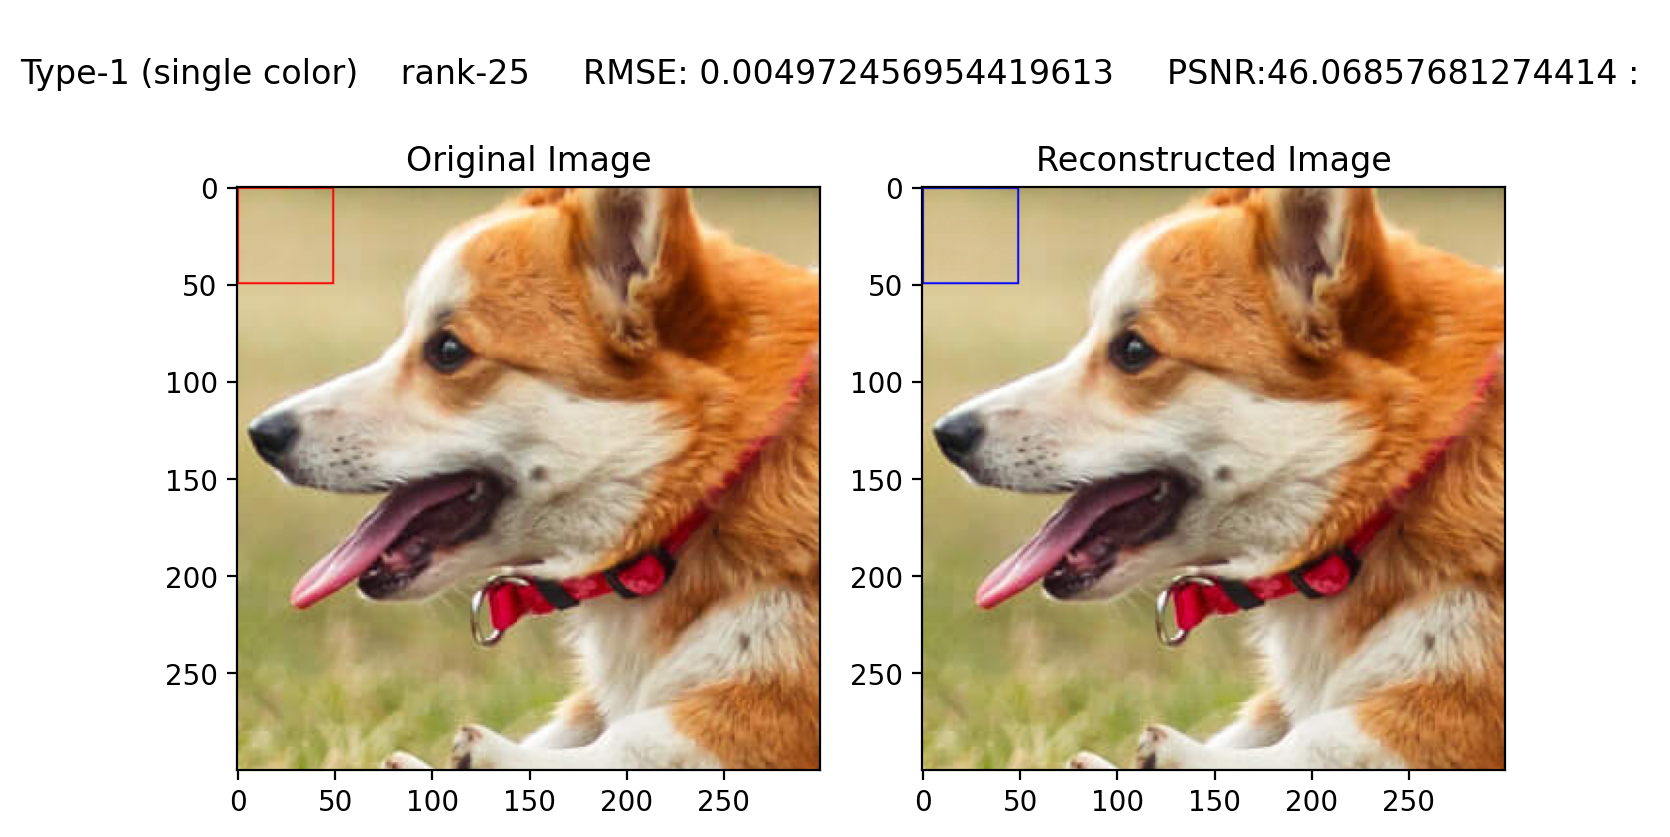

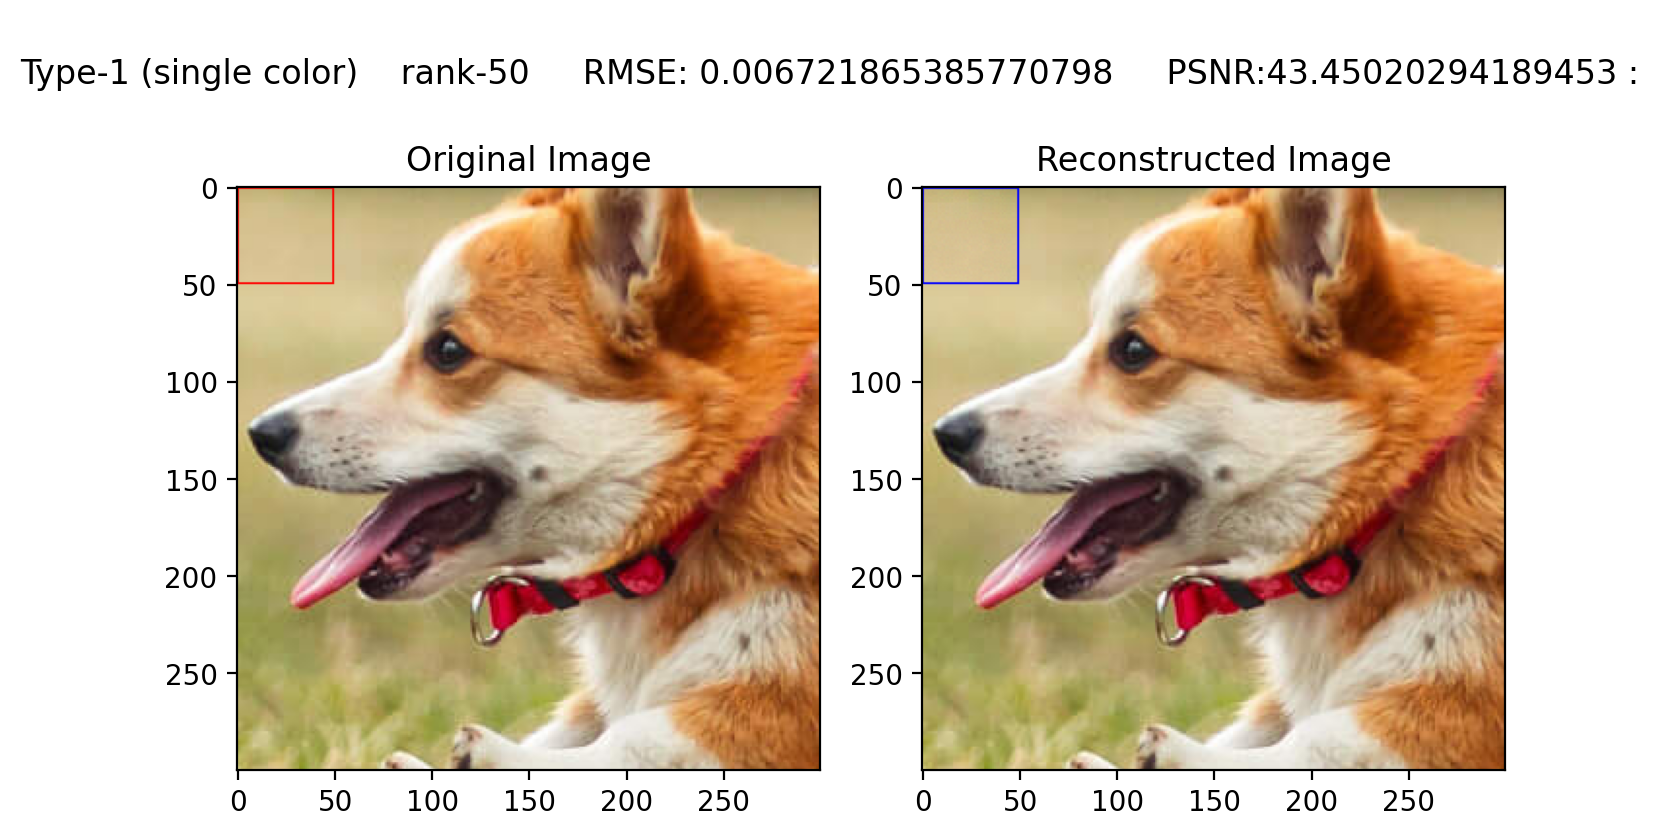

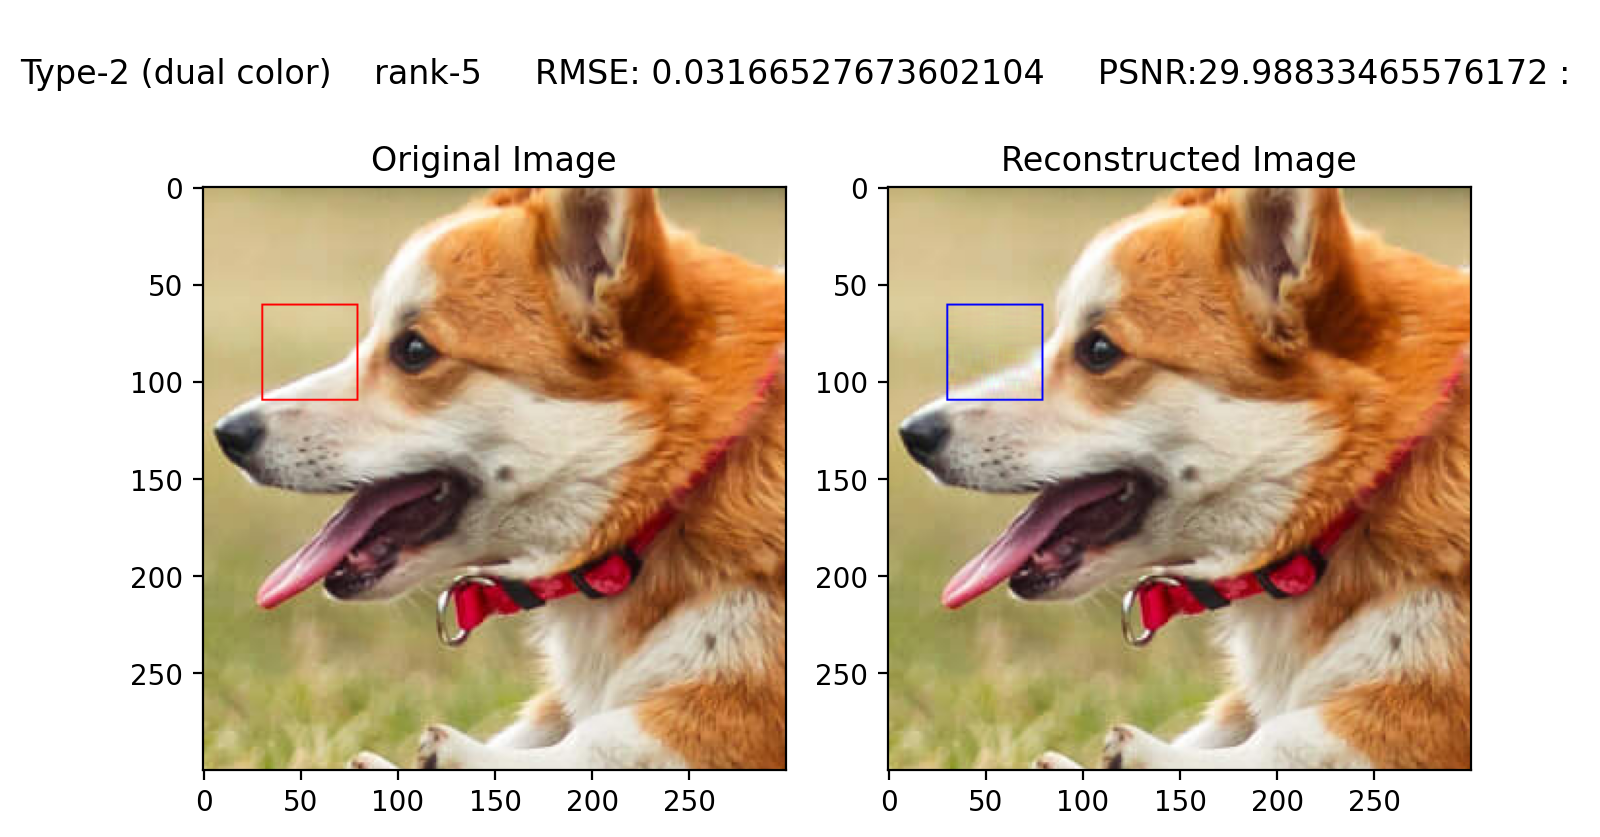

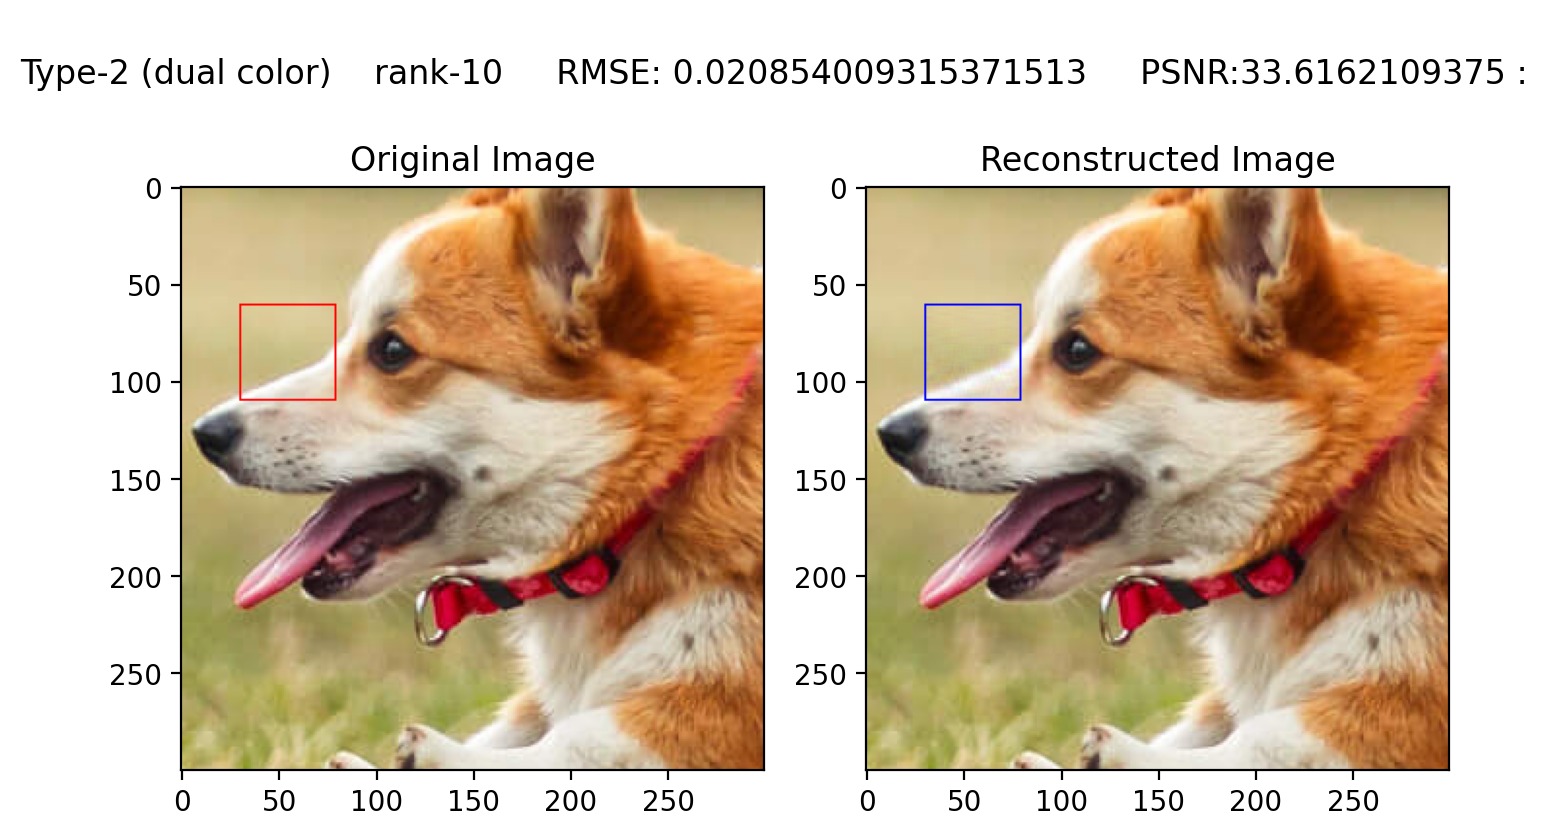

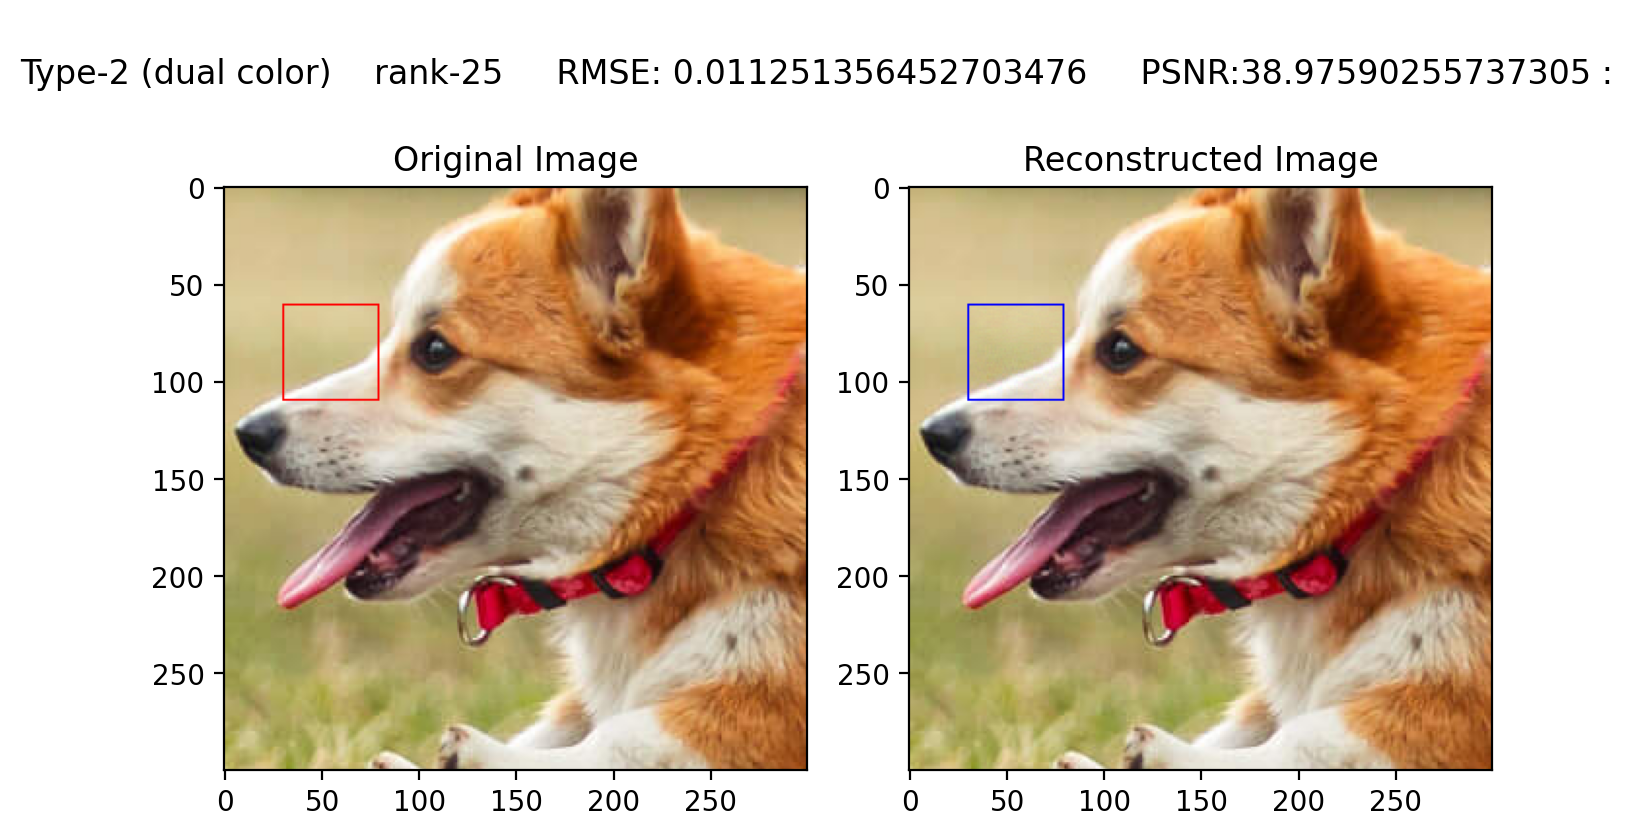

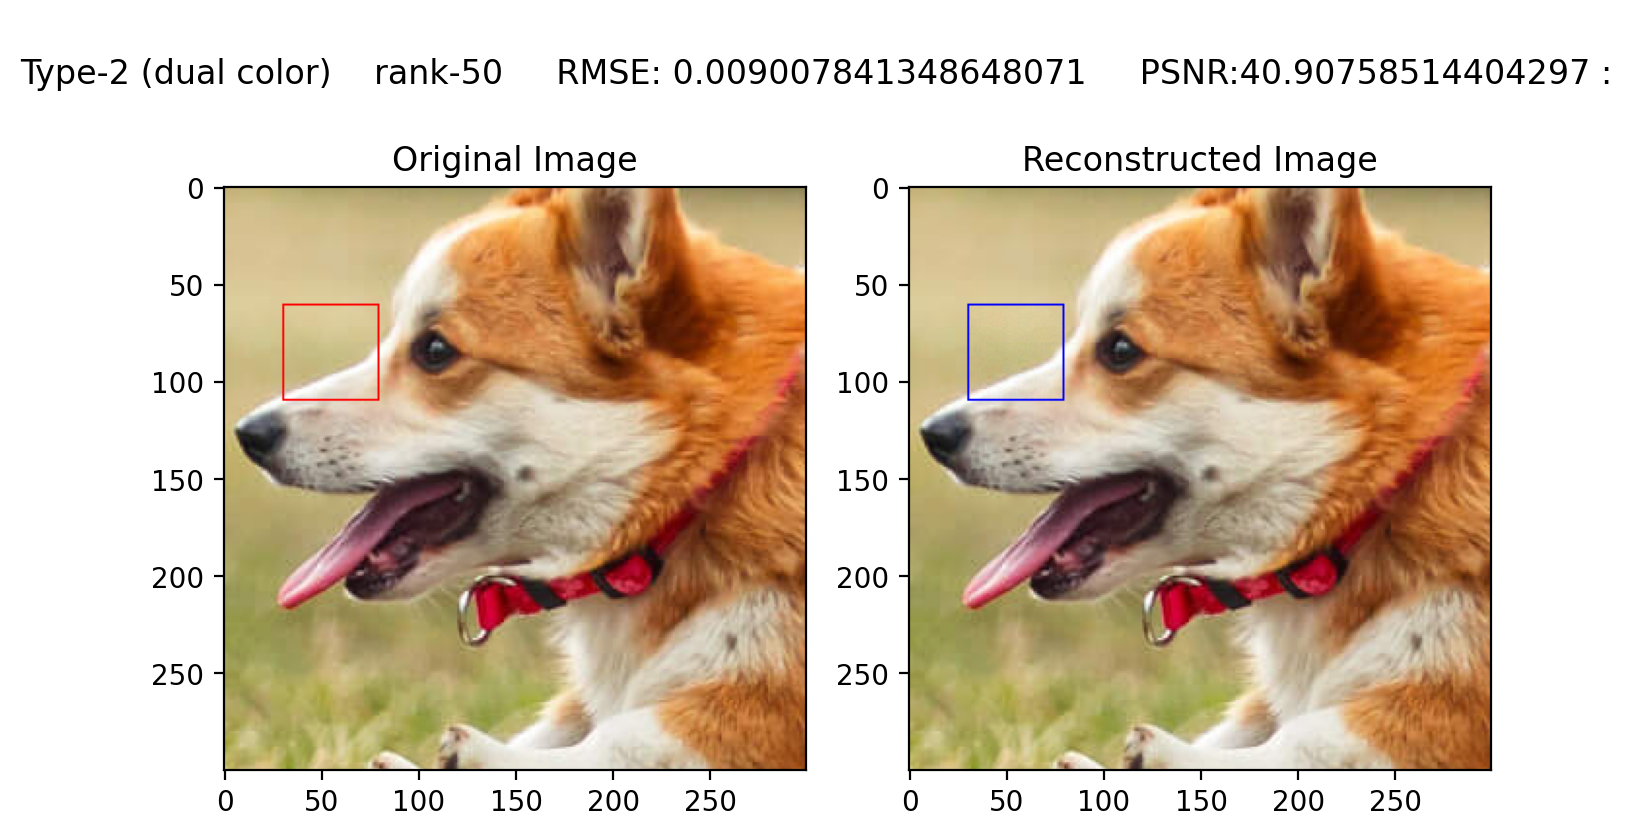

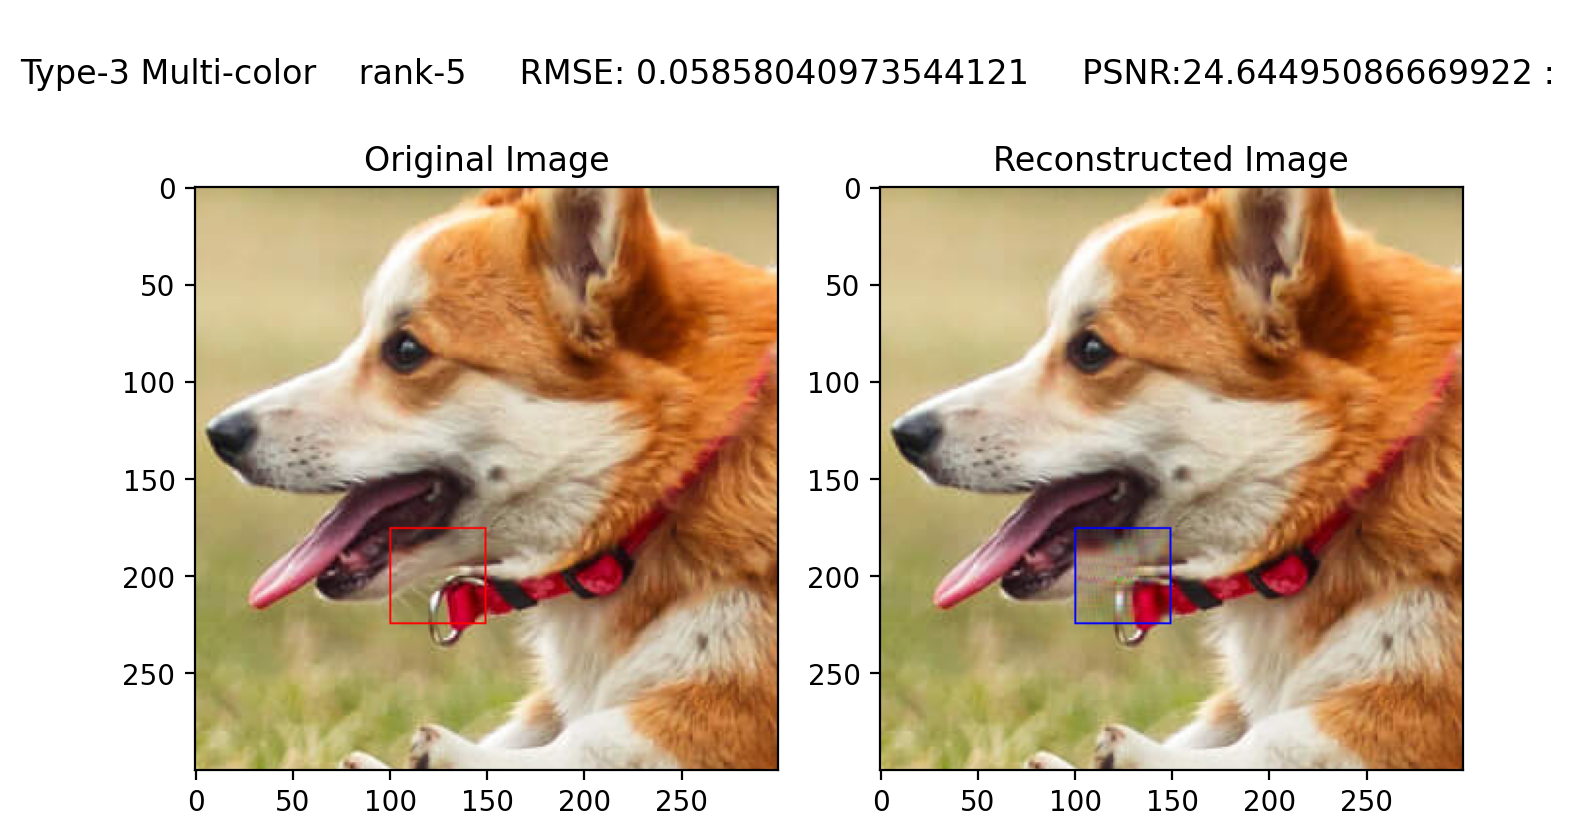

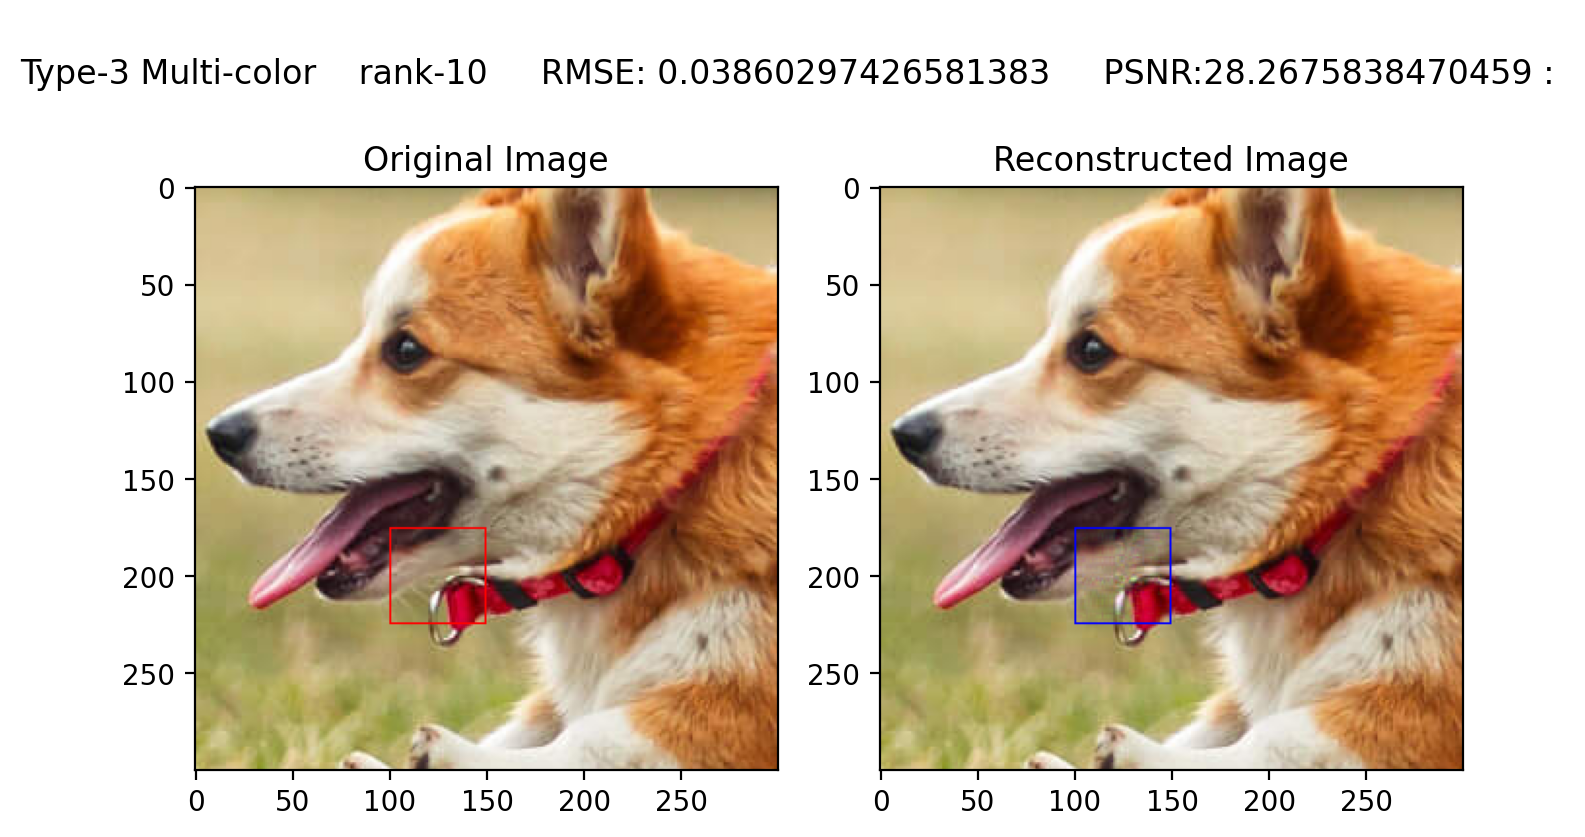

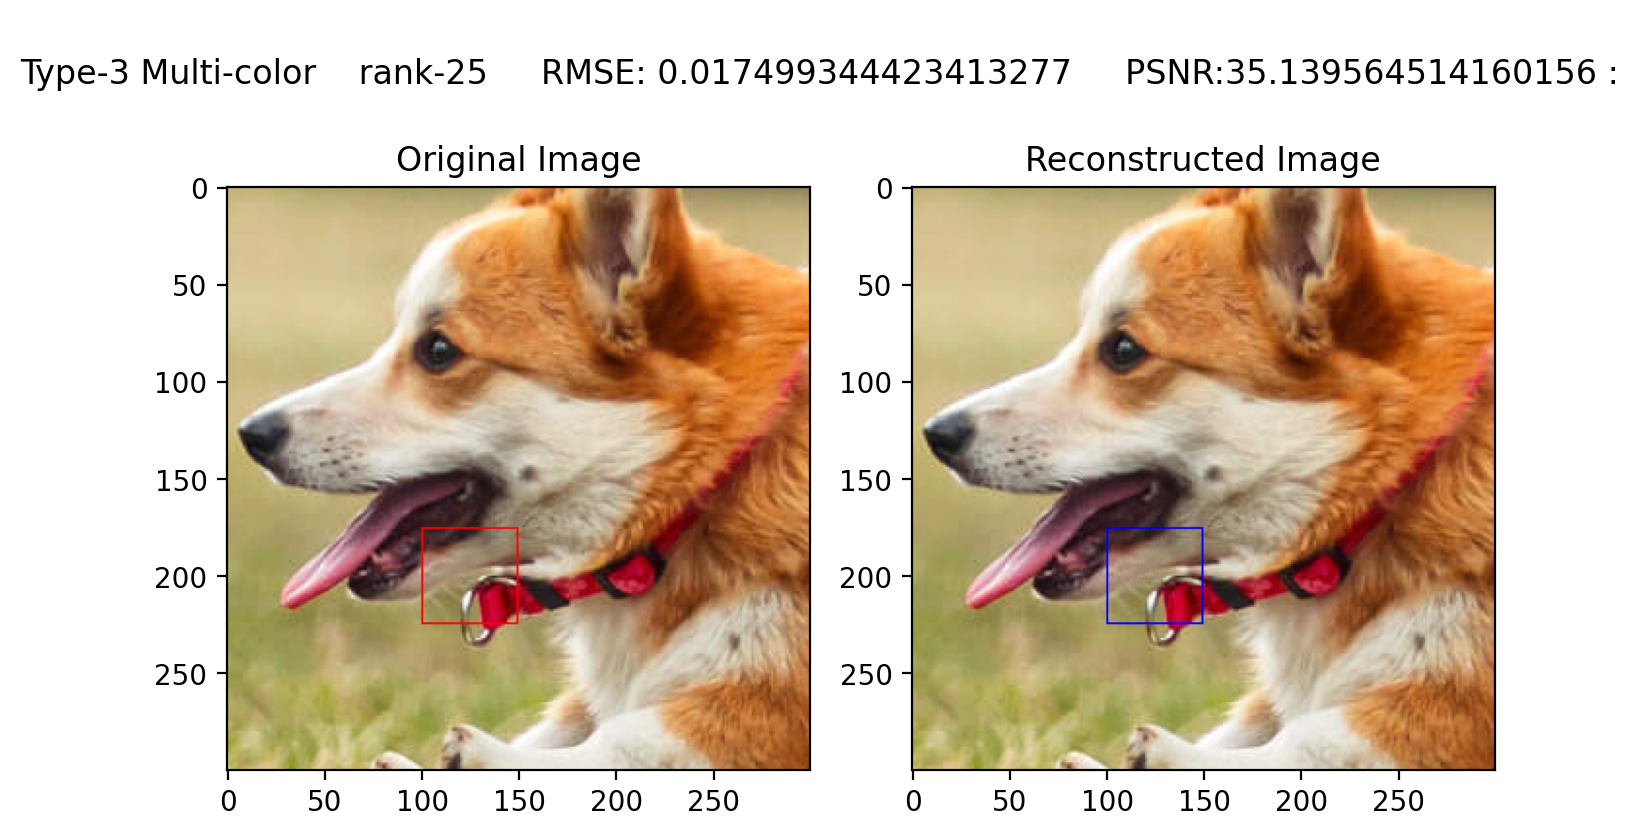

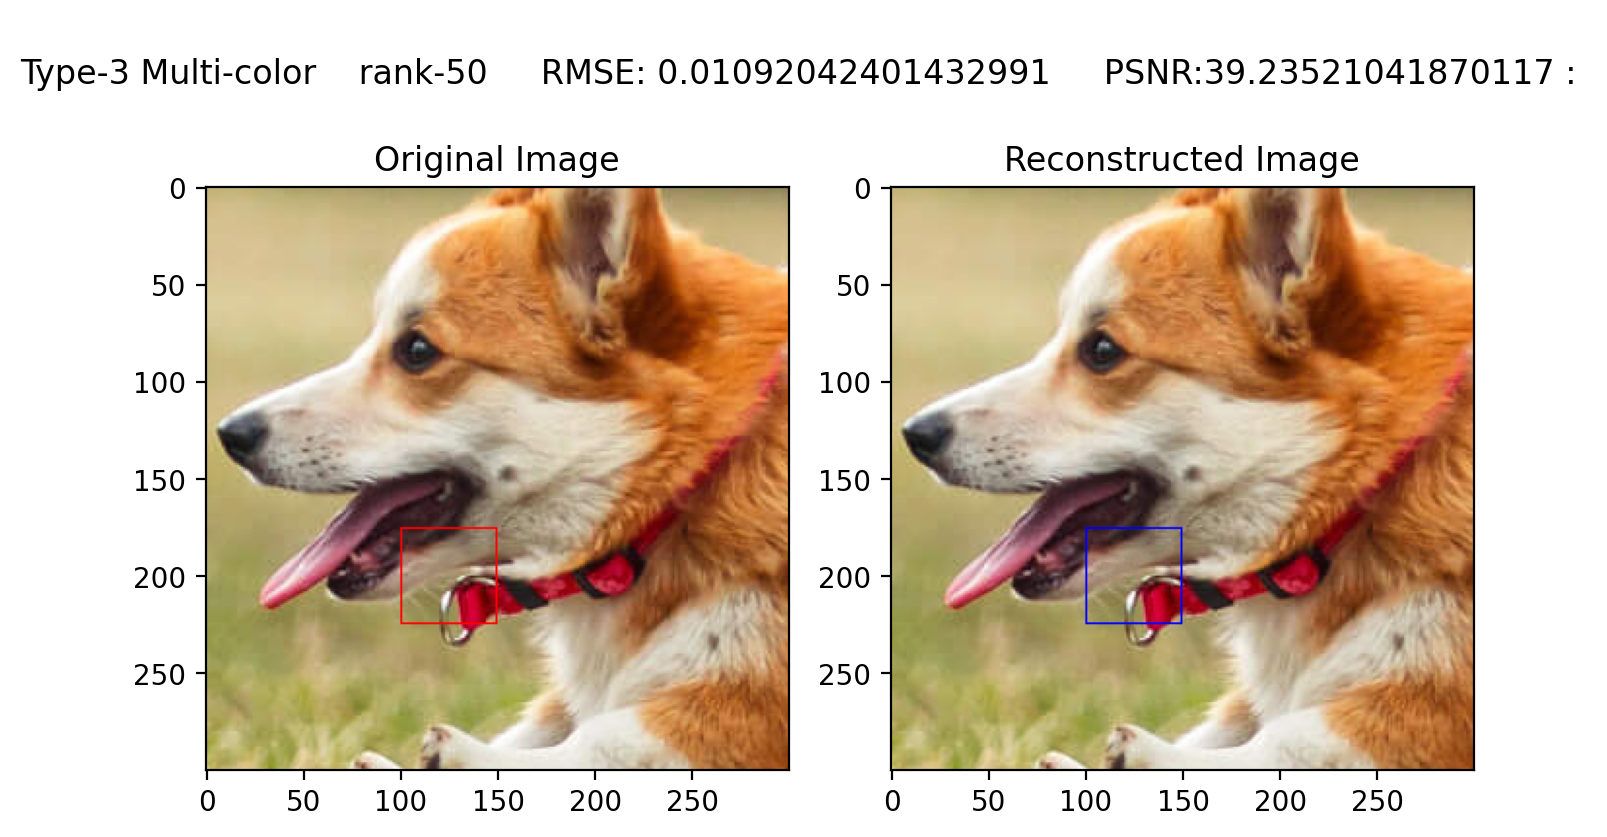

In [23]:
for  patch in patch_list:
  for rank in rank_list:
    patch_img=create_patch(sample_img,patch[0],patch[1],patch[2])
    reconstr_patch=torch.Tensor(patch_img.shape)
    W_R,H_R,loss_R=matrix_factorization(patch_img[0],rank,1000)
    W_G,H_G,loss_G=matrix_factorization(patch_img[1],rank,1000)
    W_B,H_B,loss_B=matrix_factorization(patch_img[2],rank,1000)

    with torch.no_grad():
      reconstr_patch_R=torch.mm(W_R,H_R)
      reconstr_patch_G=torch.mm(W_G,H_G)
      reconstr_patch_B=torch.mm(W_B,H_B)

    reconstr_patch=torch.stack([reconstr_patch_R,reconstr_patch_G,reconstr_patch_B],axis=-1)
    reconstr_patch=rearrange(reconstr_patch,'h w c -> c h w')

    reconstr_img=replace_patch(sample_img,patch[0],patch[1],reconstr_patch)

    rmse=get_rmse(patch_img,reconstr_patch)
    psnr=get_psnr(patch_img,reconstr_patch)

    plot_images(sample_img,reconstr_img,rank,patch[3],rmse,psnr,patch)